# Árboles de regresión y random forest para regresión y clasificación

## Librerías a utilizar

Para el tratamiento se han agregado principalmente cinco bibliotecas. En el caso de `sklearn`, se tuvo la necesidad de hacer importaciones parciales para que ciertas funciones y métodos sean detectados correctamente.

In [1]:
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn as sl

## Carga de datasets

Se usarán dos datasets los cuales serán cargados en dos dataframes. Aquel identificado como `test` solo será usado al final para completar el dataset con el modelo.

In [2]:
mainpath = "./ds/"
train = "housing_train.csv"
test = "housing_test.csv"
df_train = pd.read_csv(mainpath + train)
df_test = pd.read_csv(mainpath + test)

## Resumen de datos

Las dimensiones del dataframe, filas y columnas, se obtiene con la propiedad `shape`, los valores de las cabeceras se obtienen con la propiedad `columns.values`.

In [3]:
df_train.shape

(1460, 81)

La función `describe()` devuelve el conteo de campos no nulos, media, desviación estándar y cuantiles para columnas númericas. En las columnas identificadas como objetos (categóricas) devolverá el conteo de campos no nulos, número de valores posibles, el valor más repetido y su frecuencia. Si se desea saber el tipo de datos que tienen las columnas se usa la propiedad `dtypes`.

In [4]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [5]:
df_train.describe(include='object').transpose()

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


In [6]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Para obtener detalles por columna podemos usar `df_train['Nombre de columna'].describe()`, también es posible obtener por columna los posibles valores posibles y sus respectivas frecuencias, como en el siguiente ejemplo.

In [7]:
df_train["SaleType"].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

### Matriz de correlación

La matriz de correlación indicará que tan fuerte o débil es la relación entre dos variables. Puede leerse por columnas o por filas. En la siguiente imagen se eliminó la columna `Id`, porque no será relevante para el análisis. La claridad de la celda es directamente proporcional a una mayor correlación.

<AxesSubplot:>

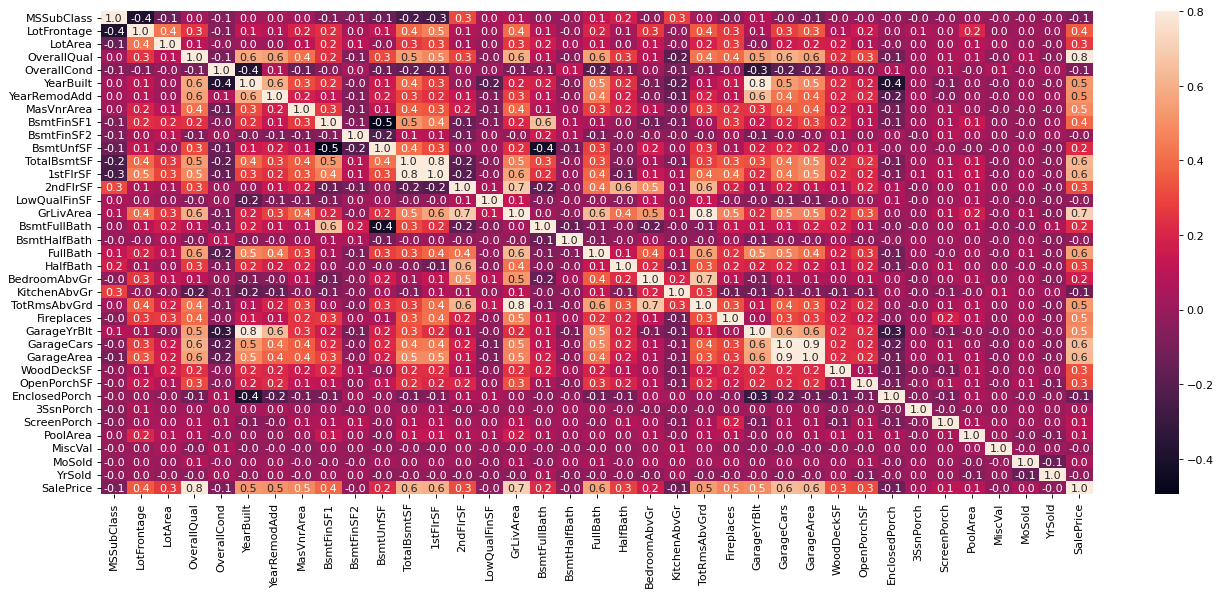

In [8]:
df_train = df_train.drop(columns = ['Id'])
plt.figure(figsize=(20,8),dpi=80)
corrmat = df_train.corr()
sns.heatmap(corrmat, vmax=.8, fmt='.1f', annot=True)

De esta forma podemos saber que variables están más relacionadas con otras. en el caso de la variable `SalePrice` las diez variables más útiles serán aquellas con mayor índice de correlación, mismas que se usarán posteriormente para las predicciones.

In [9]:
df_train.corr()['SalePrice'].sort_values(ascending=False)[1:11]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

## Valores perdidos

Trabajar con los valores perdidos requiere primero su ubicación, posteriormente se seleccionará que debe ser borrado y luego que debe ser sustituido con un nuevo valor, por supuesto habrá que decidir cual será dicho valor nuevo.

### Eliminar campos

Para ubicar si una celda tiene un valor vacío se usa la función `isnull()`, si se prefiere lógica inversa se usa `notnull`. Es posible  obtener un vector  de estos  valores con la  propiedad `values`, transformarlo  a un array con la función `ravel()` y sumar los valores verdaderos con la función `sum()`. También es posible obtener una lista ordenada de las columnas con más valores vacíos.

In [10]:
df_train.isnull().sum().sort_values(ascending=False)[0:19]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

En  el ejemplo  de  arriba, el  valor es  el  número de  valores  vacíos, si  usamos la  función `notnull()` sería el número de valores no vacíos, la suma de ambos debe ser el número total de filas obtenido anteriormente.

Hay dos razones para la falta de valores en los datasets:

- Recolección de datos: No se consiguieron los datos.
- Extracción de datos: Los datos están en la  DB original pero no se extrajeron correctamente al dataset.

Se deben evitar datos vacíos para no tener problemas de manejo de información. Se tienen dos opciones:

- Borrar las filas donde falten valores en alguna de las columnas
- Borrar las columnas donde no se tenga suficiente información

En este ejercicio es posible observar que las columnas `MiscFeature, Fence, PoolQC, FirePlaceQu y Alley` tienen muy pocos valores proporcionados (menos del 55 por ciento)y no vale la pena conservarlas. Otro criterio para asegurar un buen curso de acción es revisar las correlaciones con la columna `SalePrice`.

Como el razonamiento es el correcto se procede al borrado de columnas.

In [11]:
def toDel(df):
    for col in df.columns.values:
        nv = pd.isnull(df[col]).values.ravel().sum()
        if nv > df.shape[0] * 0.45:
            print("Deleting: "+col)
            del df[col]
    return df
df_train = toDel(df_train)

Deleting: Alley
Deleting: FireplaceQu
Deleting: PoolQC
Deleting: Fence
Deleting: MiscFeature


### Llenar campos

Es necesario detectar nuevamente que columnas tienen valores vacíos. Esta vez se reemplazarán esos valores. Hay valores númericos y categóricos vacíos; los numéricos serán reemplazados por el promedio original de la columna, los categóricos serán remplazados por el valor no nulo más cercano puede ser el valor que va antes (`ffill`) o el que va después (`bfill`), en este análisis será el segundo.

Es necesario señalar que el procedimiento más preciso para las columnas categóricas sería colocar el valor de mayor frecuencia relacionado con el valor de la columna objetivo, por ejemplo: Si la columna `Y` del dataframe es la variable dependiente y `X` es una columna categórica con valores perdidos; dichos valores se llenarán por aquel de mayor frecuencia en `X` tomando en cuenta solo aquellos con los que coincidan en `Y`. Más adelante se retomará la justificación de porque no se ha hecho de esta forma.

In [12]:
def DetectNull(df):
    candidates = []
    for col in df.columns.values:
        nv = pd.isnull(df[col]).values.ravel().sum()
        if nv > 0:
            candidates.append((col, df[col].dtype, nv))
    return candidates

In [13]:
def FillNull(df, list):
    for col in list:
        if col[1] == 'float64':
            df[col[0]] = df[col[0]].fillna(df[col[0]].mean())
        else:
            df[col[0]] = df[col[0]].fillna(method="bfill")
    return df

In [14]:
df_train = FillNull(df_train, DetectNull(df_train))
df_train.isnull().sum().sort_values(ascending=False)

MSSubClass      0
GarageYrBlt     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
               ..
MasVnrArea      0
MasVnrType      0
Exterior2nd     0
Exterior1st     0
SalePrice       0
Length: 75, dtype: int64

## Problema de regresión

### Árboles de decisión

Primero serán creados los conjuntos de prueba y entrenamiento. Serán usados para el modelo solo aquellos campos que tengan un alto índice de correlación en la matriz de correlaciones mostrada anteriormente.

In [15]:
train, test = train_test_split(df_train, test_size=0.2)
predictors = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
target = ['SalePrice']

A continuación se entrena el árbol de regresión y se ingresan los datos para probar la predicción del mismo.

In [16]:
dtr = DecisionTreeRegressor(max_depth=15, min_samples_split=20, random_state=99)
dtr.fit(train[predictors], train[target])
prediction = dtr.predict(test[predictors])

Ahora se muestran los resultados: una comparación entre los datos originales y las predicciones, además, el árbol obtenido, mismo que fue guardado en la carpeta `out` del proyecto en formato graphviz y como imagen.

In [17]:
test['preds'] = prediction
test[['SalePrice','preds']]

,SalePrice,preds
1303,232000,220733.529412
509,124500,123896.666667
1231,132500,137590.625000
619,305000,370994.500000
180,177000,175517.888889
...,...,...
1332,100000,102077.937500
512,129900,130250.000000
917,135000,137590.625000
1234,130000,129136.157895


En la tabla se observa que muchos valores de predicción están repetidos, esto se debe a que entran en la misma lógica de predicción. Debe recordarse que el árbol funciona decidiendo con valores preestablecidos.

In [18]:
with open('out/dtr.dot','w') as dotfile:
    export_graphviz(dtr, out_file=dotfile, feature_names=predictors)
    dotfile.close()

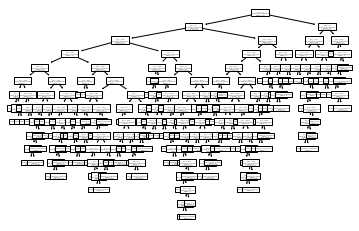

In [19]:
tree.plot_tree(dtr);

Para validar el modelo se usará un método de validación cruzada, un método estadístico para evaluar y comparar algoritmos de aprendizaje dividiendo datos en dos segmentos: entrenamiento y prueba. Típicamente, ambos conjuntos deben cruzarse en rondas sucesivas de modo que cada punto de datos tenga la posibilidad de ser validado. La forma básica es la validación cruzada k-fold.

In [20]:
dtr = DecisionTreeRegressor(max_depth=15, min_samples_split=20, random_state=99)
dtr.fit(train[predictors], train[target])
cv = KFold(n_splits = 20, shuffle = True, random_state = 1)
score = np.mean(cross_val_score(dtr, train[predictors], train[target], scoring = "neg_mean_squared_error", cv = cv, n_jobs = 1))
score

-1604183909.7172432

El modelo es muy deficiente según el error cuadrático medio de pérdida. Este error es muy grande, debería ser cercano a cero. Sería mejor probar un modelo lineal, los árboles de regresión son útiles si es necesario estimar un modelo no lineal. Para confirmar se realizará este modelo bajo diferentes profundidades del árbol, de esta forma se podría encontrar un mejor conjunto de parámetros, no sucede en este caso.

In [21]:
for i in range(1,21):
    dtr = DecisionTreeRegressor(max_depth=i, min_samples_split=20, min_samples_leaf=5,random_state=99)
    dtr.fit(train[predictors], train[target])
    cv = KFold(n_splits = 20, shuffle = True, random_state = 1)
    score = np.mean(cross_val_score(dtr, train[predictors], train[target], scoring = "neg_mean_squared_error", cv = cv, n_jobs = 1))
    print("Score para i=",i,": ",score)

Score para i= 1 :  -3601015173.999565
Score para i= 2 :  -2568559122.5972424
Score para i= 3 :  -2206637786.646313
Score para i= 4 :  -1903910546.201511
Score para i= 5 :  -1746555914.9694176
Score para i= 6 :  -1718487361.5824573
Score para i= 7 :  -1635397674.812034
Score para i= 8 :  -1600955745.9334507
Score para i= 9 :  -1599074295.9367273
Score para i= 10 :  -1599517111.9685142
Score para i= 11 :  -1598644129.9437797
Score para i= 12 :  -1656531471.7930772
Score para i= 13 :  -1660241481.1008537
Score para i= 14 :  -1604241931.2117047
Score para i= 15 :  -1604259897.2306924
Score para i= 16 :  -1604259897.2306924
Score para i= 17 :  -1604259897.2306924
Score para i= 18 :  -1604259897.2306924
Score para i= 19 :  -1604259897.2306924
Score para i= 20 :  -1604259897.2306924


### Random Forest

Al igual que en la sección anterior, se entrena el modelo con los mismos conjuntos definidos anteriormente y se hace una predicción.

In [22]:
rfr = RandomForestRegressor(n_jobs = 1, oob_score=True, n_estimators=10000)
rfr.fit(train[predictors], train[target].values.ravel())
prediction = rfr.predict(test[predictors])
test['preds'] = prediction
test[['SalePrice','preds']]

,SalePrice,preds
1303,232000,230258.232600
509,124500,131604.857500
1231,132500,146528.400500
619,305000,327448.271200
180,177000,176640.003633
...,...,...
1332,100000,95313.180067
512,129900,123358.971100
917,135000,133911.802800
1234,130000,119655.763000


Como puede verse, un bosque de diez mil árboles las estimaciones los valores se acercan notablemente. Esto puede confirmarse con la puntuación propia del bosque, la cual funciona como el coeficiente de determinación de un modelo de regresión.

In [23]:
rfr.oob_score_

0.8339813541052516

La conclusión es que sería mejor usar un modelo de regresión que un modelo de decisión porque pese a la mejora sustancial respecto al árbol anterior, el bosque no alcanza un 0.9 en la puntuación, condición que se le exigiría a un modelo lineal.

## Problema de clasificación
### Creación de categorías de SalesPrice

Ahora se procederá a crear categorías con la columna `SalePrice`. Para ello se ha escrito una función y una nueva columna dentro del dataframe.

In [24]:
def SalePriceGroupValue(x):
    if x >= 500001:
        return 'G3'
    elif x <= 100000:
        return 'G1'
    return 'G2'
df_train["SalePriceGroup"] = df_train["SalePrice"].apply(SalePriceGroupValue)
df_train["SalePriceGroup"].value_counts()

G2    1328
G1     123
G3       9
Name: SalePriceGroup, dtype: int64

Aquí es posible observar que la gran mayoria de los datos se encuentran en la categoría `G2`. Esto confirma que la opción antes seleccionada para llenar datos perdidos es buena debido a que binda una posibilidad de preservar datos las otras categorías.

### Árboles de decisión

Se repetirá el procedimiento visto anteriormente, la diferencia es que ahora usará `DecisionTreeClassifier`. 

In [25]:
train, test = train_test_split(df_train, test_size=0.2)

In [26]:
colnames = df_train.columns.values.tolist()
predictors = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
target = colnames[75]
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=20, random_state=99)
dtc.fit(train[predictors], train[target])
prediction = dtc.predict(test[predictors])

Se ha creado una tabla cruzada que logra visualizar los resultados, además es posible usar metricas simples para verificar la exactitud del árbol.

In [27]:
pd.crosstab(test[target], prediction, colnames=["Predictions"], rownames=["Real"])

Predictions,G1,G2
Real,,
G1,12,19
G2,1,256
G3,0,4


In [28]:
print("Accuracy: ", metrics.accuracy_score(prediction, test[target]))

Accuracy:  0.9178082191780822


In [29]:
with open('out/dtc.dot','w') as dotfile:
    export_graphviz(dtc, out_file=dotfile, feature_names=predictors)
    dotfile.close()

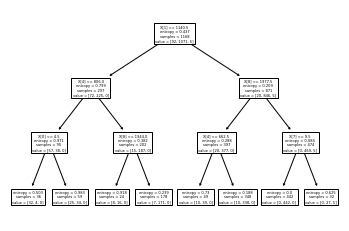

In [30]:
tree.plot_tree(dtc);

Al usar nuevamente validación cruzada se observa que una buena clasificación esta entre `i=3` e `i=6`, lo que significa que si se deja crecer el árbol desde el nodo raíz con estas profundidades es posible obtener clasificaciones óptimas. También podemos ver que las variables de mayor importancia clasificatoria son `TotalBsmtSF` y `GrLivArea`.

In [31]:
for i in range(1,10):
    dtc = DecisionTreeClassifier(criterion="entropy", max_depth=i, min_samples_split=20, random_state=99)
    dtc.fit(train[predictors], train[target])
    cv = KFold(n_splits = 20, shuffle = True, random_state = 1)
    score = np.mean(cross_val_score(dtc, train[predictors], train[target], scoring = "accuracy", cv = cv, n_jobs = 1))
    print("Score para i=",i,": ",score)
    print("Importancia de variables: \n\t",dtc.feature_importances_)

Score para i= 1 :  0.91697837521917
Importancia de variables: 
	 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Score para i= 2 :  0.9281852717708942
Importancia de variables: 
	 [0.         0.4901448  0.         0.         0.36373115 0.
 0.         0.         0.14612405 0.        ]
Score para i= 3 :  0.9298509643483343
Importancia de variables: 
	 [0.06481814 0.36847    0.         0.         0.32627153 0.
 0.         0.08043738 0.16000296 0.        ]
Score para i= 4 :  0.9298509643483343
Importancia de variables: 
	 [0.0713111  0.33284723 0.02356823 0.03024587 0.29818061 0.01238634
 0.         0.06728182 0.13383442 0.03034437]
Score para i= 5 :  0.9298363530099356
Importancia de variables: 
	 [0.06500573 0.34277622 0.03598013 0.05023336 0.27181533 0.01129113
 0.         0.06133272 0.12200072 0.03956466]
Score para i= 6 :  0.9298655756867328
Importancia de variables: 
	 [0.06146586 0.30882661 0.03402084 0.06397364 0.29499275 0.02596007
 0.         0.05799286 0.11535719 0.03741017]
Score para i= 7 :  

### Random Forest

En la implementación de este bosque se usa el mismo procedimiento visto anteriormente, es importante poner atención en los cambios de los argumentos de cada árbol, cada implementación dependerá del problema.

In [32]:
rfc = RandomForestClassifier(n_jobs = 1, oob_score=True, n_estimators=10000)
rfc.fit(train[predictors], train[target])
prediction = rfc.predict(test[predictors])
test['preds'] = prediction
test[['SalePriceGroup','preds']]

,SalePriceGroup,preds
1426,G2,G2
865,G2,G2
719,G2,G2
1073,G2,G2
862,G2,G2
...,...,...
196,G2,G2
50,G2,G2
1364,G2,G2
252,G2,G2


En esta ocasión se ha aumentado la exactitud del árbol, es posible decir que se ha creado un modelo confible.     

In [33]:
rfc.oob_score_

0.9434931506849316

## Conclusión